In [ ]:
! pip install --upgrade xgboost
!pip install xgbse

## xgboost survival embedding : data7/Autoencoder data

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split
# importing xgbse 
from xgbse._kaplan_neighbors import DEFAULT_PARAMS
from xgbse.metrics import concordance_index

# importing model and utils from xgbse
from xgbse import XGBSEKaplanNeighbors
from xgbse.converters import convert_to_structured

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/7.Autoencoder.xlsx')

df = df.drop(['Lot No.'], axis = 1)

encoding_dict = {0 : False, 1 : True}

df['event'] = df['event'].replace(encoding_dict)
df


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,y_cum_time,event
0,0,12.722068,0.758748,0.0,0.0,13.207268,9.582267,11.466477,0.000000,0.0,858.57,False
1,0,15.588124,1.220959,0.0,0.0,15.535728,11.400229,14.285864,0.000000,0.0,858.57,False
2,0,13.741526,1.261623,0.0,0.0,14.729326,10.034328,12.279980,0.000000,0.0,858.57,False
3,0,14.839289,1.666825,0.0,0.0,14.260595,11.127079,13.225833,0.000000,0.0,858.57,False
4,0,14.911379,2.277337,0.0,0.0,13.867559,11.282560,12.411875,0.000000,0.0,838.28,False
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,10.465731,0.000000,0.0,0.0,14.693747,4.279375,4.924776,0.000000,0.0,956.02,True
296,0,14.541126,1.336442,0.0,0.0,17.409590,7.626169,8.618668,0.000000,0.0,946.02,True
297,0,14.142028,0.631848,0.0,0.0,17.827446,7.065281,8.120098,0.000000,0.0,520.35,True
298,0,5.994473,0.000000,0.0,0.0,10.300678,1.880372,1.396609,0.568676,0.0,234.13,True


In [ ]:
train, test = train_test_split(df, test_size = 0.3, random_state = 30)

X_train = train.drop(['event', 'y_cum_time'], axis = 1)
X_test = test.drop(['event', 'y_cum_time'], axis = 1)

y_train = np.array(list(zip(train['event'], train['y_cum_time'])), dtype = "?,f")
y_test = np.array(list(zip(test['event'], test['y_cum_time'])), dtype = "?,f")

# chaning parameter
DEFAULT_PARAMS['aft_loss_distribution_scale'] = 0.75

# training model
xgbse_model = XGBSEKaplanNeighbors(DEFAULT_PARAMS, n_neighbors=25)
xgbse_model.fit(
    X_train, y_train,
    validation_data = (X_train, y_train),
    early_stopping_rounds=10,
    time_bins=np.arange(0, 6000, 30)
)

# predicting and evaluating
preds = xgbse_model.predict(X_test)
cind = concordance_index(y_test, preds)

print(f"C-index: {cind:.3f}")
print("----")

C-index: 0.682
----


In [ ]:
import copy
result = copy.deepcopy(preds.T)

pred = []
real = []
check = []
for j in range(len(result.columns)):
    real.append(y_test[j][1])
    check.append(y_test[j][0])
    for i in range(len(result)):
        if result.iloc[len(result)-1, j] >= 0.5:
            pred.append(result.index[len(result)-1])
            break
            
        elif result.iloc[i,j] < 0.5:
            #print(result.iloc[i-1:i+1,j])
            a = result.iloc[i-1,j] - 0.5
            b = 0.5 - result.iloc[i,j] 
            v = (a*result.index[i]+b*result.index[i-1])/(a+b)
            #print(pred)
            pred.append(v)
            break

prediction = pd.DataFrame()
prediction['pred'] = pred
prediction['real'] = real
prediction['gas_leak'] = check
prediction

,pred,real,gas_leak
0,605.836364,476.279999,True
1,604.521531,535.419983,False
2,660.681818,1192.420044,False
3,616.041667,682.500000,False
4,436.669501,276.100006,True
...,...,...,...
85,3084.816054,1124.349976,False
86,600.238636,437.850006,True
87,608.221154,636.429993,False
88,484.446429,182.279999,True


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


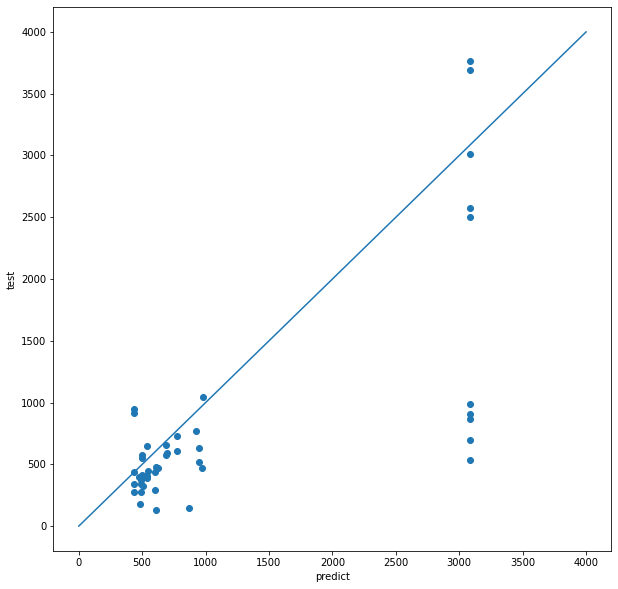

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(prediction[prediction['gas_leak']==1]['pred'], prediction[prediction['gas_leak']==1]['real'])
plt.plot([1,100,1000,4000],[1,100,1000,4000])
plt.xlabel("predict")
plt.ylabel("test")
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


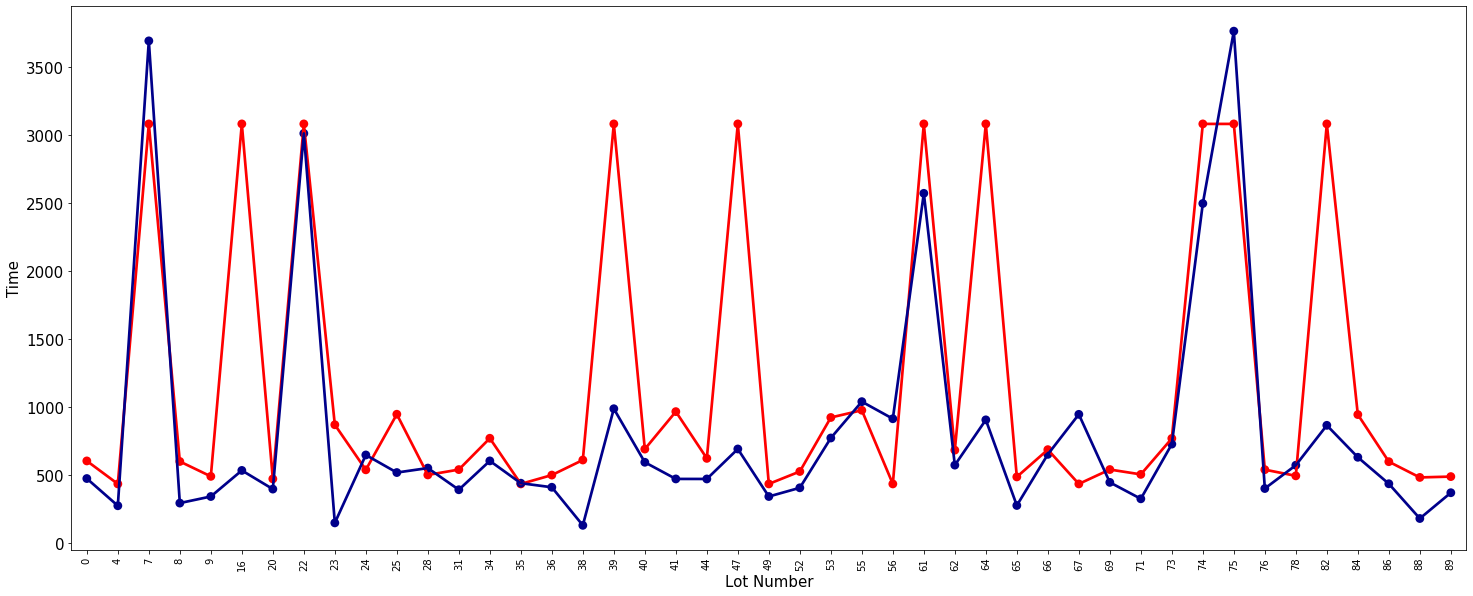

In [ ]:
import seaborn as sns

plt.figure(figsize=(25,10))
sns.pointplot(x = 'index', y='pred', data=prediction[prediction['gas_leak']==1].reset_index(), color='Red', label='y_pred')
sns.pointplot(x = 'index', y='real', data=prediction[prediction['gas_leak']==1].reset_index(), color='DarkBlue', label='y_test')

plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=15)
plt.xlabel("Lot Number", fontsize=15)
plt.ylabel("Time", fontsize=15)
plt.show()

### xgboost survival:aft : data 5/RFECV Seperate data
-->  feature importance 도출에 사용

In [ ]:



df = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/5.RFECV Seperate.xlsx')

df = df.drop(['Lot No.'], axis = 1)
encoding_dict = {0 : False, 1 : True}

df['event'] = df['event'].replace(encoding_dict)
train, test = train_test_split(df, test_size = 0.3, random_state = 30)
X_train = train.drop(['event', 'y_cum_time'], axis = 1)
X_test = test.drop(['event', 'y_cum_time'], axis = 1)

y_train = np.array(list(zip(train['event'], train['y_cum_time'])), dtype = "?,f")
y_test = np.array(list(zip(test['event'], test['y_cum_time'])), dtype = "?,f")



# chaning parameter
DEFAULT_PARAMS['aft_loss_distribution_scale'] = 0.75

# training model
xgbse_model = XGBSEKaplanNeighbors(DEFAULT_PARAMS, n_neighbors=25)
xgbse_model.fit(
    X_train, y_train,
    validation_data = (X_train, y_train),
    early_stopping_rounds=10,
    time_bins=np.arange(0, 6000, 30)
)

# predicting and evaluating
preds = xgbse_model.predict(X_test)
cind = concordance_index(y_test, preds)

print(f"C-index: {cind:.3f}")
print("----")



C-index: 0.625
----


In [ ]:
import xgboost as xgb
from xgbse.metrics import concordance_index
from xgbse._kaplan_neighbors import DEFAULT_PARAMS

df = pd.read_excel('/content/gdrive/MyDrive/FactoryHack2022/Final/data/5.RFECV Seperate.xlsx')

df = df.drop(['Lot No.'], axis = 1)
encoding_dict = {0 : False, 1 : True}

df['event'] = df['event'].replace(encoding_dict)
train, test = train_test_split(df, test_size = 0.3, random_state = 30)
X_train = train.drop(['event', 'y_cum_time'], axis = 1)
X_test = test.drop(['event', 'y_cum_time'], axis = 1)

y_train = np.array(list(zip(train['event'], train['y_cum_time'])), dtype = "?,f")
y_test = np.array(list(zip(test['event'], test['y_cum_time'])), dtype = "?,f")


train.reset_index(inplace = True)
y_lower_bound = train['y_cum_time'].to_numpy()
y_upper_bound = train['y_cum_time'].copy().to_numpy()
alive_index = train[train['event'] == 0].index
y_upper_bound[alive_index] = +np.inf

dtrain = xgb.DMatrix(X_train)
dtrain.set_float_info('label_lower_bound', y_lower_bound)
dtrain.set_float_info('label_upper_bound', y_upper_bound)

test.reset_index(inplace = True)
test_y_lower_bound = test['y_cum_time'].to_numpy()
test_y_upper_bound = test['y_cum_time'].copy().to_numpy()
alive_index = test[test['event'] == 0].index
test_y_upper_bound[alive_index] = +np.inf

dtest = xgb.DMatrix(X_test)
dtest.set_float_info('label_lower_bound', test_y_lower_bound)
dtest.set_float_info('label_upper_bound', test_y_upper_bound)

# chaning parameter
DEFAULT_PARAMS['aft_loss_distribution_scale'] = 0.75


# training model
bst = xgb.train(
    DEFAULT_PARAMS,
    dtrain,
    num_boost_round = 500,
    early_stopping_rounds=10,
    evals = [(dtest,'eval'), (dtrain,'train')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dtest)
cind = concordance_index(y_test, -preds, risk_strategy="precomputed")

print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")
print("----")

feature_importance = bst.get_score(importance_type='gain')
feature_importance = sorted(feature_importance.items(), key=lambda item: item[1], reverse = True)
feature_importance

C-index: 0.622
Average survival time: 799 days
----


[('2-버너회전수', 15.692426681518555),
 ('핀치두께2-하', 4.179741382598877),
 ('1-버너회전수', 2.4125943183898926),
 ('전압(2차)', 2.363227128982544),
 ('2-수소공급량', 2.3093318939208984),
 ('강도', 2.2796218395233154),
 ('전압(1차)', 2.242271900177002),
 ('전력(2차)', 2.10447359085083),
 ('온도(2차)', 2.03861665725708),
 ('2-버너속도', 2.0088579654693604),
 ('1-산소공급량', 1.622000813484192)]